# Decision trees from scratch

In [2]:
import pandas
import numpy
import math
import matplotlib
from matplotlib import pyplot
import seaborn
from StringIO import StringIO
%matplotlib inline

C:\Users\Hua\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Parse CSV dataset into a (pandas) dataframe

In [4]:
weather_csv = StringIO("""outlook,temperature,humidity,windy,label
sunny,hot,high,false,n
sunny,hot,high,True,n
overcast,hot,high,False,p
rain,mild,high,False,p
rain,cool,normal,False,p
rain,cool,normal,True,n
overcast,cool,normal,True,p
sunny,mild,high,False,n
sunny,cool,normal,False,p
rain,mild,normal,False,p
sunny,mild,normal,True,p
overcast,mild,high,True,p
overcast,hot,normal,False,p""")

weather = pandas.read_csv(weather_csv)
weather[:3]

,outlook,temperature,humidity,windy,label
0,sunny,hot,high,False,n
1,sunny,hot,high,True,n
2,overcast,hot,high,False,p


## Attributes for each observation

```
outlook = {sunny, overcast, rain}

temperature = {hot, mild, cool}

humidity = {high, normal}

windy = {true, false}
```

### Extracting all examples where we want to play golf

In [5]:
weather[weather.label == 'p']

,outlook,temperature,humidity,windy,label
2,overcast,hot,high,False,p
3,rain,mild,high,False,p
4,rain,cool,normal,False,p
6,overcast,cool,normal,True,p
8,sunny,cool,normal,False,p
9,rain,mild,normal,False,p
10,sunny,mild,normal,True,p
11,overcast,mild,high,True,p
12,overcast,hot,normal,False,p


In [6]:
# Convert the string features to categorical features
for c in weather.columns:
    weather[c] = weather[c].astype('category')
weather

,outlook,temperature,humidity,windy,label
0,sunny,hot,high,False,n
1,sunny,hot,high,True,n
2,overcast,hot,high,False,p
3,rain,mild,high,False,p
4,rain,cool,normal,False,p
5,rain,cool,normal,True,n
6,overcast,cool,normal,True,p
7,sunny,mild,high,False,n
8,sunny,cool,normal,False,p
9,rain,mild,normal,False,p


In [7]:
# categories provide a stable string => ordinal assignment
list(zip(weather.humidity, weather.humidity.cat.codes))

[('high', 0),
 ('high', 0),
 ('high', 0),
 ('high', 0),
 ('normal', 1),
 ('normal', 1),
 ('normal', 1),
 ('high', 0),
 ('normal', 1),
 ('normal', 1),
 ('normal', 1),
 ('high', 0),
 ('normal', 1)]

## Computing entropy of a set of examples

In [8]:
CLASSES = weather.label.unique()
CLASSES

[n, p]
Categories (2, object): [n, p]

In [9]:
# implement info gain on this categorical data
examples = weather[:]
class_counts = examples.groupby('label').size()
total_count = len(examples)

total_entropy = 0
for class_label, class_count in examples.groupby('label').size().iteritems():
    class_prob = float(class_count) / total_count
    print 'P(%s) = %.2f' % (class_label, class_prob)
    total_entropy += -(class_prob * math.log(class_prob, 2))
print 'total entropy: %.3f' % total_entropy

P(n) = 0.31
P(p) = 0.69
total entropy: 0.890


In [10]:
def entropy(examples):
    total_entropy = 0
    for class_label, class_count in examples.groupby('label').size().iteritems():
        if class_count > 0:
            class_prob = float(class_count) / total_count
            total_entropy += -(class_prob * math.log(class_prob, 2))
    return total_entropy

entropy(weather[:]), entropy(weather[:10])

(0.8904916402194913, 1.0380478597756913)

## Computing information gain from a proposed attribute split

Selecting subsets from the dataframe based on attribute value

In [12]:
weather[weather['humidity'] == 'high']

,outlook,temperature,humidity,windy,label
0,sunny,hot,high,False,n
1,sunny,hot,high,True,n
2,overcast,hot,high,False,p
3,rain,mild,high,False,p
7,sunny,mild,high,False,n
11,overcast,mild,high,True,p


In [13]:
def info_gain(examples, attribute):
    total_gain = entropy(examples)

    for attr_value in examples[attribute].unique():
        attr_subset = examples[examples[attribute] == attr_value]
        if len(attr_subset):
            total_gain -= len(attr_subset) / float(len(examples)) * entropy(attr_subset)
    
    return total_gain
    
info_gain(examples, 'humidity')

0.009365598883735893

## Finding a split on discrete-valued features

In [14]:
feature_cols = [c for c in weather.columns if c != 'label']
feature_cols

['outlook', 'temperature', 'humidity', 'windy']

In [15]:
for c in feature_cols:
    print 'InfoGain(%s) = %.3f' % (c, info_gain(examples, c))

InfoGain(outlook) = 0.144
InfoGain(temperature) = 0.086
InfoGain(humidity) = 0.009
InfoGain(windy) = -0.030


In [16]:
def find_split(current_set):
    print 'Splitting %d examples with current entropy %.3f' % (
        len(current_set), entropy(current_set))
    
    best_gain = None
    split_attr = None
    for c in feature_cols:
        gain = info_gain(current_set, c)
        #print 'InfoGain(%s) = %.3f' % (c, gain)
        if best_gain is None or gain > best_gain:
            split_attr = c
            best_gain = gain
            
    #print 'Max info gain split for attr %s of %.3f' % (split_attr, best_gain)
    return split_attr
        
find_split(examples)

Splitting 13 examples with current entropy 0.890


'outlook'

## Building the tree recusively

In [17]:
def build_tree(current_examples):
    if len(current_examples) == 1:
        return current_examples.iloc[0].label
    
    split_attr = find_split(current_examples)
    split_attr_values = current_examples[split_attr].unique()
    tree = []
    for v in split_attr_values:
        v_subset = current_examples[current_examples[split_attr] == v]
        v_subtree = build_tree(v_subset)
        tree.append((v, v_subtree))

    return tree
    
build_tree(examples)

Splitting 13 examples with current entropy 0.890
Splitting 5 examples with current entropy 0.904
Splitting 2 examples with current entropy 0.415
Splitting 2 examples with current entropy 0.569
Splitting 4 examples with current entropy 0.523
Splitting 2 examples with current entropy 0.415
Splitting 4 examples with current entropy 0.773
Splitting 3 examples with current entropy 0.488
Splitting 2 examples with current entropy 0.415


[('sunny',
  [('hot', [(False, 'n'), (True, 'n')]),
   ('mild', [('high', 'n'), ('normal', 'p')]),
   ('cool', 'p')]),
 ('overcast',
  [('hot', [('high', 'p'), ('normal', 'p')]), ('cool', 'p'), ('mild', 'p')]),
 ('rain',
  [(False, [('high', 'p'), ('normal', [('cool', 'p'), ('mild', 'p')])]),
   (True, 'n')])]

## Splitting on continuous attributes

In [3]:
wine = pandas.read_csv(StringIO('''\
fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class
5.3,0.31,0.38,10.5,53.0,140.0,3.34,0
8.2,0.885,0.2,1.4,7.0,31.0,3.11,1
7.3,0.38,0.23,6.5,18.0,102.0,3.1,0
7.3,1.07,0.09,1.7,10.0,89.0,3.3,1
7.2,0.54,0.27,2.6,12.0,78.0,3.39,1
6.3,0.22,0.22,5.6,31.0,128.0,3.12,0
6.2,0.3,0.17,2.8,24.0,125.0,3.01,0
6.5,0.38,0.26,5.2,33.0,112.0,3.06,0
6.7,0.25,0.26,13.5,50.0,156.0,3.39,0
6.4,0.38,0.24,7.2,41.0,151.0,3.11,0
7.6,0.36,0.49,11.3,87.0,221.0,3.01,0
6.5,0.36,0.28,3.2,29.0,119.0,3.25,0
6.6,0.38,0.28,2.8,17.0,67.0,3.21,0
7.3,0.26,0.32,1.2,29.0,94.0,3.07,0
15.0,0.21,0.44,2.2,10.0,24.0,3.07,1
7.9,0.19,0.26,2.1,8.0,143.0,3.05,0
8.5,0.25,0.31,2.8,11.0,61.0,3.06,0
7.7,0.64,0.21,2.2,32.0,133.0,3.27,1
7.4,0.24,0.42,14.0,48.0,198.0,2.89,0
6.8,0.22,0.35,17.5,38.0,153.0,3.24,0
7.1,0.31,0.38,1.2,10.0,124.0,3.14,0
6.5,0.37,0.33,3.5,23.0,92.0,3.18,0
7.1,0.28,0.49,6.5,28.0,111.0,3.41,0
12.2,0.45,0.49,1.4,3.0,6.0,3.13,1
7.2,0.66,0.33,2.5,34.0,102.0,3.27,1
6.8,0.18,0.28,8.5,52.0,242.0,3.22,0
7.6,0.3,0.27,10.6,31.0,119.0,3.27,0
6.2,0.2,0.32,2.8,17.0,126.0,3.18,0
7.4,0.16,0.27,15.5,25.0,135.0,2.9,0
6.8,0.34,0.69,1.3,12.0,171.0,3.06,0'''))
wine.groupby('class').size()

class
0    23
1     7
dtype: int64

In [4]:
wine[:3]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,free_sulfur_dioxide,total_sulfur_dioxide,ph,class
0,5.3,0.310,0.38,10.5,53.0,140.0,3.34,0
1,8.2,0.885,0.20,1.4,7.0,31.0,3.11,1
2,7.3,0.380,0.23,6.5,18.0,102.0,3.10,0


In [13]:
len(wine)

30


## Using scikit-learn

In [5]:
wine_label_col = 'class'
wine_feature_cols = [c for c in wine.columns if c != wine_label_col]

In [6]:
import sklearn.tree

dtree = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
dtree.fit(wine[wine_feature_cols], wine[wine_label_col])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [7]:
class_preds = dtree.predict(wine[wine_feature_cols])
class_preds

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0], dtype=int64)

In [8]:
num_correct = 0
for pred, actual in zip(class_preds, wine['class']):
    if pred == actual:
        num_correct +=1
print 'Accuracy on training set: %.1f%%' % (num_correct / float(len(wine)) * 100 )

Accuracy on training set: 100.0%


## Visualizing your tree models

You'll need to go install [graphviz](http://www.graphviz.org/) for the following to work, and also the python `pydot` package.

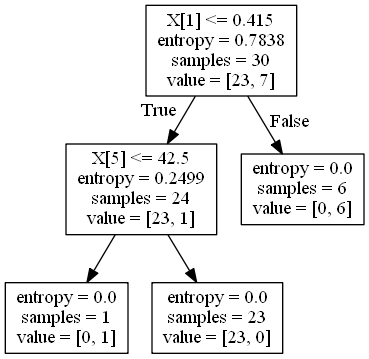

In [11]:
from IPython.display import Image
import pydot

def tree_viz(sklearn_dtree):
    temp_buffer = StringIO() # use an in-memory file-like object instead of tmp file
    sklearn.tree.export_graphviz(sklearn_dtree, out_file=temp_buffer)
    temp_buffer.seek(0) # rewind the in-memory buffer to start
    graph, = pydot.graph_from_dot_data(temp_buffer.read())  
    return Image(graph.create_png()) 

tree_viz(dtree)

ImportError: No module named site
